In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.model_selection import train_test_split
import pandas as pd
import torch_maml

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def loss_fn(model, data, device):
    inputs, targets = data
    predicted = model(inputs.to(device=device))
#     print(predicted, targets)
    loss = F.mse_loss(predicted, targets.to(device=device))
    return loss

In [ ]:
import torch.nn.functional as F
# Neural Network Architecture 
# Linear, output units: 40
# ReLU 
# Linear, output units: 1

class maml_m1(nn.Module):
    def __init__(self, nz):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 40, bias=True),
            nn.ReLU(),
            nn.Linear(40, 1, bias=True)
        )
    
    def get_weights(self):
        weights_dict = {}
        for name, parameter in self.net.named_parameters():
            weights_dict[name] = parameter
        return weights_dict
    
    def adapt_forward(self, x, weights_dict):
        x = F.linear(x, weights_dict['0.weight'], weights_dict['0.bias'])
        x = F.relu(x)
        x = F.linear(x, weights_dict['2.weight'], weights_dict['2.bias'])
        return x
    
    def forward(self, x):
        return self.net(x)

In [ ]:
# load landS file 
landS_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/landS_sample5.csv')
# split the data file 
landS_train, landS_val = train_test_split(landS_data, test_size=0.2)

# load landS2 file 
landS2_data = pd.read_csv('/Users/raoniveditha/Documents/CSCI566/Project/datasets/landS2_sample4.csv')
# split the data file 
landS2_train, landS2_val = train_test_split(landS2_data, test_size=0.2)

In [ ]:
# set up data loader 
batch_size = 40
nworkers = 4
landS_train_data_loader = torch.utils.data.DataLoader(landS_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS_val_data_loader = torch.utils.data.DataLoader(landS_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

landS2_train_data_loader = torch.utils.data.DataLoader(landS2_train.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)
landS2_val_data_loader = torch.utils.data.DataLoader(landS2_val.to_numpy(), batch_size=batch_size, shuffle=True, num_workers=nworkers)

In [ ]:
# dictionary for the data loader 
train_data_loader = {}
val_data_loader = {}

tasks = ['landS', 'landS2']
train_data_loader['landS'] = landS_train_data_loader
train_data_loader['landS2'] = landS2_train_data_loader

val_data_loader['landS'] = landS_val_data_loader
val_data_loader['landS2'] = landS2_val_data_loader

In [ ]:
beta = 1e-5
alpha = 1e-5
nz = 7 # number of input units 
optimizer = torch_maml.IngraphGradientDescent(learning_rate=0.0001)
# optimizer = torch_maml.IngraphRMSProp(learning_rate=0.01, beta=0.0008, epsilon=0.0001)
model = maml_m1(nz).to(device=device)
maml = torch_maml.GradientCheckpointMAML(model, loss_fn, optimizer=optimizer, checkpoint_steps=5)
maml_steps = 3000

# Clip meta-learning gradients by global norm to avoid explosion
max_grad_grad_norm = 1e2


In [ ]:
inputs = None
outputs = None
batch = None
for data in landS_train_data_loader:
    input_size = data.shape[1]
#     x = data[:,:-1].clone().detach()
    ip_data = data[:,:-1].clone().detach().to(dtype=torch.float)
    inner_loop_sample = F.pad(input=ip_data, pad=(0,2,0,0), mode='constant', value=0)
#     print(inner_loop_sample)
    h_value = data[:,-1].clone().detach().to(dtype=torch.float)
    outputs = h_value.view(-1,1)
    inputs = [(inner_loop_sample, outputs)] * maml_steps
    batch = inner_loop_sample
    print(batch.shape, outputs.shape)
    break

torch.Size([40, 7]) torch.Size([40, 1])


Loss naive: 8.8527


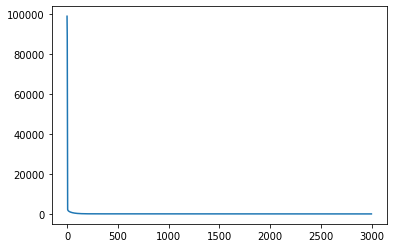

In [ ]:
updated_model, loss_history, _ = maml(inputs, loss_kwargs={'device':device}, max_grad_grad_norm=max_grad_grad_norm)
final_loss = loss_fn(updated_model, (batch, outputs), device=device)
final_loss.backward()
grads = [params.grad for params in model.parameters()]
print("Loss naive: %.4f" % final_loss.item())
# print(loss_history)
plt.plot(loss_history)

In [ ]:
inputs = None
outputs = None
batch = None
for data in landS2_train_data_loader:
    input_size = data.shape[1]
#     x = data[:,:-1].clone().detach()
    inner_loop_sample = data[:,:-1].clone().detach().to(dtype=torch.float)
#     print(inner_loop_sample)
    h_value = data[:,-1].clone().detach().to(dtype=torch.float)
    outputs = h_value.view(-1,1)
    inputs = [(inner_loop_sample, outputs)] * maml_steps
    batch = inner_loop_sample
    break

Loss naive: 5.3847


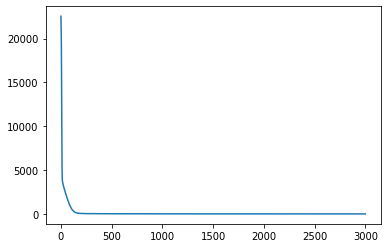

In [ ]:
updated_model, loss_history, _ = maml(inputs, loss_kwargs={'device':device}, max_grad_grad_norm=max_grad_grad_norm)
final_loss = loss_fn(updated_model, (batch, outputs), device=device)
final_loss.backward()
grads = [params.grad for params in model.parameters()]
print("Loss naive: %.4f" % final_loss.item())
# print(loss_history)
plt.plot(loss_history)